# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [2]:
import io
import os
import numpy as np
import scipy

In [3]:
PATH_TO_DATA = r"./data/"

# 1) Monolingual (English) word embeddings 

In [22]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort
        list_score = [self.score(w,w_dico) for w_dico in self.word2vec]
        if max(list_score)>0:
            index_best_words = (np.argsort(list_score)[::-1][:K])
            return list(np.array(self.word2vec.keys())[index_best_words])
        else:
            print('The word given as input is not in the pretrained vocabulary')
            return []

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        if w1 in self.word2vec:
            emb1 = self.word2vec[w1]
        if w2 in self.word2vec:
            emb2 = self.word2vec[w2]
        if (w1 in self.word2vec)and(w2 in self.word2vec):
            return emb1.dot(emb2.T)/(np.linalg.norm(emb1)*np.linalg.norm(emb2))
        else:
            return 0


In [5]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=25000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 25000 pretrained word vectors
('cat', 'dog', 0.67168366627924903)
('dog', 'pet', 0.68420640296692192)
('dogs', 'cats', 0.70743893280524039)
('paris', 'france', 0)
('germany', 'berlin', 0)
[u'cat', u'cats', u'kitty', u'kitten', u'Cat']
[u'dog', u'dogs', u'puppy', u'Dog', u'canine']
[u'dogs', u'dog', u'Dogs', u'puppies', u'cats']
The word given as input is not in the pretrained vocabulary
[]
The word given as input is not in the pretrained vocabulary
[]


In [6]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        idf_dic = idf
        for sent in sentences:
            if idf is False:
                # mean of word vectors
                list_embeddings = [self.w2v.word2vec[w] for w in sent if w in w2v.word2vec]
                if len(list_embeddings)==0: #if any word in the sentence is in our lookup table
                    sentemb.append(np.zeros(self.w2v.word2vec.values()[0].shape))
                else:
                    sentemb.append(np.mean(list_embeddings, axis=0))
            else:
                # idf-weighted mean of word vectors
                list_embeddings = [idf_dic[w]*self.w2v.word2vec[w] for w in sent if w in w2v.word2vec]
                if len(list_embeddings)==0: #if any word in the sentence is in our lookup table
                    sentemb.append(np.zeros(self.w2v.word2vec.values()[0].shape))
                else:
                    sentemb.append(np.mean(list_embeddings, axis=0))
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        #keys = self.encode(sentences, idf)
        #query = self.encode([s], idf)
        list_score = [self.score(s,key_sent,idf) for key_sent in sentences]
        index_best_sent = (np.argsort(list_score)[::-1][:K])
        all_sent = []
        print('Top-%s NNs of \n"%s"\n\n' % (K, ' '.join(s)))
        if max(list_score)>0:
            for i,ind_best in enumerate(index_best_sent):
                print('%s) %s' % (i + 1, ' '.join(sentences[ind_best])))
                all_sent.append(sentences[ind_best])
        else: #empty sentence or sentence with unknown words
            print 'The sentence given as input doesn t contains words that are present in the loaded vocabulary'
        return all_sent

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        emb2 = self.encode([s2], idf)
        emb1 = self.encode([s1], idf)
        if ((np.linalg.norm(emb1)!=0) and ((np.linalg.norm(emb2)!=0))):
            return emb1.dot(emb2.T)/(np.linalg.norm(emb1)*np.linalg.norm(emb2))
        else: #if an embedding as a zero vector
            return 0
                                           
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            for w in set(sent):
                idf[w] = idf.get(w, 0) + 1        
        for w in idf:
            idf[w] = max(1, np.log10(len(sentences) / (idf[w])))
        return idf

In [192]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=5000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"

with open(os.path.join(PATH_TO_DATA,'sentences.txt')) as f:
    sentences = f.readlines()

sentences = [sent.split() for sent in sentences]
# Build idf scores for each word
idf = {} if False else s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))

s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

Loaded 5000 pretrained word vectors
Top-5 NNs of 
"1 smiling african american boy ."


1) 1 smiling african american boy .
2) blond boy waterskiing .
3) a boy jumps .
4) a boy jumps .
5) a boy smiles underwater .
[[ 0.60894451]]
Top-5 NNs of 
"1 smiling african american boy ."


1) 1 smiling african american boy .
2) 5 women and 1 man are smiling for the camera .
3) a man rides a 4 wheeler in the desert .
4) 3 males and 1 woman enjoying a sporting event
5) a man in black is juggling 3 flamed bottles .
[[ 0.59651552]]


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [6]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

w2v_eng = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=50000)
w2v_fr = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax=50000)





Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [7]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

words_in_both_vocab = [w for w in w2v_eng.word2vec if w in w2v_fr.word2vec]
X = np.vstack([w2v_eng.word2vec[w] for w in words_in_both_vocab])
Y = np.vstack([w2v_fr.word2vec[w] for w in words_in_both_vocab])


In [8]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

# TYPE CODE HERE
import scipy.linalg as la

X = X[:100]
Y = Y[:100]
U, s, Vh = la.svd(Y.dot(X.T))
W = U.dot(Vh)


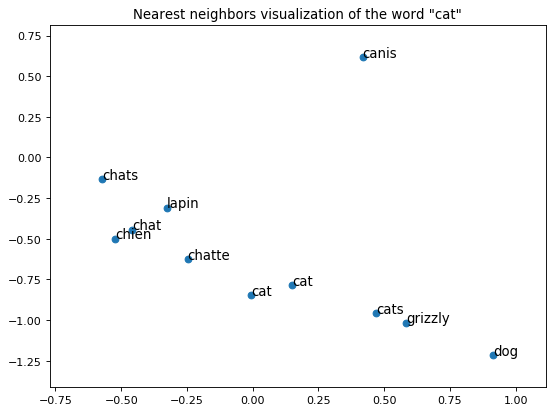

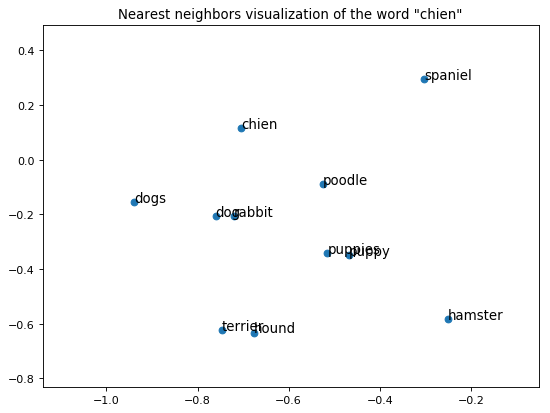

In [34]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

# TYPE CODE HERE
import scipy.linalg as la
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

%matplotlib inline  

#I have build a full class for this part in order to have a modular architecture

class BilingualWord2Vec:
    #Class that allows to compute and visualize the alignement from one class to another one
    def __init__(self, w2v_1,w2v_2):
        self.w2v_lang_1 = w2v_1
        self.w2v_lang_2 = w2v_2
        
    def build_alignement(self,max_size):
        #Solve the Procrustes probelm from language 1 to language 2 and give the optimal alinement matrix
        words_in_both_vocab = [w for w in self.w2v_lang_1.word2vec if w in self.w2v_lang_2.word2vec]
        words_in_both_vocab = words_in_both_vocab[:max_size]
        X = np.vstack([self.w2v_lang_1.word2vec[w] for w in words_in_both_vocab]).T
        Y = np.vstack([self.w2v_lang_2.word2vec[w] for w in words_in_both_vocab]).T
        
        U, s, Vh = la.svd(Y.dot(X.T))
        return U.dot(Vh)
    
    def mostsimilarother_lang(self,word,W_alignement,K=5,lang_input = 1,lang_output=2):
        #word : input word
        #W_alignement : alignement from input word to output
        #K: number of nearest neightbor
        #lang_input: input language
        #lang_output: output language (similar words language)
        if lang_input == 1: #settings in order to let the choice of input and output language
            word2vec_1 = self.w2v_lang_1.word2vec
        else:
            word2vec_1 = self.w2v_lang_2.word2vec
        
        if lang_output == 1:  #settings in order to let the choice of input and output language
            word2vec_2 = self.w2v_lang_1.word2vec
        else:
            word2vec_2 = self.w2v_lang_2.word2vec
            
        query = W_alignement.dot(word2vec_1[word]) if word in word2vec_1 else 0 #projection in output space
        keys = word2vec_2.values()
        
        list_score = [self.score(query,key) for key in keys]
        index_best_words = (np.argsort(list_score)[::-1][:K])
        
        return np.array(word2vec_2.keys())[index_best_words] #return K most similar words

    def score(self, emb1, emb2):
        # cosine similarity: np.dot  -  np.linalg.norm
        if ((np.linalg.norm(emb1)!=0) and ((np.linalg.norm(emb2)!=0))):
            return emb1.dot(emb2.T)/(np.linalg.norm(emb1)*np.linalg.norm(emb2))
        else:
            return 0
        
    def plotsimilarwordother_lang(self,word,W_alignement,pca,K=5,lang_input = 1,lang_output=2):
        #This function plots the word given as input in the output space embedding given the alignement matrix
        #It is inspire from the TP1
        #word : input word
        #W_alignement : alignement from input word to output
        #K: number of nearest neightbor
        #lang_input: input language
        #lang_output: output language (similar words language)
        if lang_input == 1:  #settings in order to let the choice of input and output language
            word2vec_1 = self.w2v_lang_1.word2vec
        else:
            word2vec_1 = self.w2v_lang_2.word2vec
        
        if lang_output == 1:  #settings in order to let the choice of input and output language
            word2vec_2 = self.w2v_lang_1.word2vec
        else:
            word2vec_2 = self.w2v_lang_2.word2vec
            
            
        arr = np.empty((0,word2vec_2.values()[0].shape[0]), dtype='f')
        word_labels = [word]
        # get close words
        close_words = self.mostsimilarother_lang(word,W_alignement,K,lang_input,lang_output)
        # add the vector for each of the closest words to the array
        pos_word = W_alignement.dot(word2vec_1[word]) if word in word2vec_1 else np.zeros(word2vec_2.values()[0].shape)
        arr = np.append(arr, np.array([pos_word]), axis=0)
        for wrd_score in close_words:
            wrd_vector = word2vec_2[wrd_score]
            word_labels.append(wrd_score)
            arr = np.append(arr, np.array([wrd_vector]), axis=0)

        # find tsne coords for 2 dimensions
        np.set_printoptions(suppress=True)
        Y = pca.transform(arr)

        x_coords = Y[:, 0]
        y_coords = Y[:, 1]
        # display scatter plot
        plt.figure(figsize=(8, 6), dpi=80)
        plt.scatter(x_coords, y_coords)

        for label, x, y in zip(word_labels, x_coords, y_coords):
            plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=12)
        plt.xlim(x_coords.min()-0.2, x_coords.max()+0.2)
        plt.ylim(y_coords.min()-0.2, y_coords.max()+0.2)
        plt.title('Nearest neighbors visualization of the word "%s"' % word)

        plt.show()
        
biw2vec = BilingualWord2Vec(w2v_eng,w2v_fr)
W = biw2vec.build_alignement(19000) 
pca = PCA(n_components=2)
pca.fit(np.array(biw2vec.w2v_lang_2.word2vec.values()))
biw2vec.plotsimilarwordother_lang('cat',W,pca,K=10) #test with the english word cat
biw2vec.plotsimilarwordother_lang('chien',W.T,pca,K=10,lang_input=2,lang_output=1) #test with the french word cat




If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [7]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

def read_training(file_path):
    #This function allows to read the SST training file
    with open(file_path,'r') as f:
        lines = f.readlines()
    y_train= [int(line[0]) for line in lines] 
    x_train= [line[2:].split() for line in lines]
    return x_train,y_train

def read_test(file_path):
    #This function allows to read the SST test file
    with open(file_path,'r') as f:
        lines = f.readlines()
    x_test = [line.split() for line in lines]
    return x_test

x_train,y_train = read_training(os.path.join(PATH_TO_DATA,'SST','stsa.fine.train'))
x_dev,y_dev = read_training(os.path.join(PATH_TO_DATA,'SST','stsa.fine.dev'))
x_test = read_test(os.path.join(PATH_TO_DATA,'SST','stsa.fine.test.X'))

In [49]:
# 2 - Encode sentences with the BoV model above
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=50000)
s2v = BoV(w2v)

idf = {} if False else s2v.build_idf(x_train+x_dev+x_test)

x_train_encode = s2v.encode(x_train)

x_dev_encode = s2v.encode(x_dev)

x_test_encode = s2v.encode(x_test)

x_train_encode_idf = s2v.encode(x_train,idf)

x_dev_encode_idf = s2v.encode(x_dev,idf)


# TYPE CODE HERE

Loaded 50000 pretrained word vectors


In [52]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression(C= 0.7,max_iter=1000,tol=1e-10)
lr.fit(x_train_encode,y_train)
prediction_dev = lr.predict(x_dev_encode)
prediction_train = lr.predict(x_train_encode)

lr_idf = LogisticRegression(C= 0.5,max_iter=1000,tol=1e-10)
lr_idf.fit(x_train_encode_idf,y_train)
prediction_dev_idf = lr_idf.predict(x_dev_encode_idf)
prediction_train_idf = lr_idf.predict(x_train_encode_idf)


print 'Precision sur le train set', accuracy_score(y_train,prediction_train)
print 'Precision sur le dev set', accuracy_score(y_dev,prediction_dev)


print 'Precision sur le train set idf', accuracy_score(y_train,prediction_train_idf)
print 'Precision sur le dev set idf ', accuracy_score(y_dev,prediction_dev_idf)


Precision sur le train set 0.455407303371
Precision sur le dev set 0.406902815622
Precision sur le train set idf 0.46172752809
Precision sur le dev set idf  0.384196185286


In [74]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

def write_submission(path_output,prediction):
    #function that write the submission
    lines = '\n'.join([str(p) for p in prediction])
    with open(path_output,'w') as f:
        f.writelines(lines)

    

prediction_test = lr.predict(x_test_encode)
write_submission(os.path.join('.',r'logreg_bov_y_test_sst.txt'),prediction_test)


In [35]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(x_train_encode,y_train) #No extra regularization, bagging is enough in general
prediction_dev_rf = rf_classifier.predict(x_dev_encode)
prediction_train_rf = rf_classifier.predict(x_train_encode)


rf_classifier_idf = RandomForestClassifier(n_estimators=100)
rf_classifier_idf.fit(x_train_encode_idf,y_train) #No extra regularization, bagging is enough in general
prediction_dev_rf_idf = rf_classifier_idf.predict(x_dev_encode_idf)
prediction_train_rf_idf = rf_classifier_idf.predict(x_train_encode_idf)


print 'Random Forest Precision sur le train set', accuracy_score(y_train,prediction_train_rf)
print 'Random Forest Precision sur le dev set', accuracy_score(y_dev,prediction_dev_rf)

print 'Random Forest Precision sur le train set idf', accuracy_score(y_train,prediction_train_rf_idf)
print 'Random Forest Precision sur le dev set idf', accuracy_score(y_dev,prediction_dev_rf_idf)


xgb_classifier = XGBClassifier(max_depth=3,n_estimators=300,reg_lambda=1) #with early stopping based on val set
xgb_classifier.fit(x_train_encode,y_train,verbose=False,early_stopping_rounds=30,eval_metric='mlogloss',eval_set=[(x_train_encode,y_train),(x_dev_encode,y_dev)])
# TYPE CODE HERE
prediction_dev_xgb = xgb_classifier.predict(x_dev_encode)
prediction_train_xgb = xgb_classifier.predict(x_train_encode)

xgb_classifier_idf = XGBClassifier(max_depth=3,n_estimators=300,reg_lambda=1) #with early stopping based on val set
xgb_classifier_idf.fit(x_train_encode_idf,y_train,verbose=False,early_stopping_rounds=30,eval_metric='mlogloss',eval_set=[(x_train_encode,y_train),(x_dev_encode,y_dev)])
# TYPE CODE HERE
prediction_dev_xgb_idf = xgb_classifier_idf.predict(x_dev_encode_idf)
prediction_train_xgb_idf = xgb_classifier_idf.predict(x_train_encode_idf)


print 'XGBoost Precision sur le train set', accuracy_score(y_train,prediction_train_xgb)
print 'XGBoost  Precision sur le dev set', accuracy_score(y_dev,prediction_dev_xgb)

print 'XGBoost Precision sur le train set idf', accuracy_score(y_train,prediction_train_xgb_idf)
print 'XGBoost  Precision sur le dev set idf', accuracy_score(y_dev,prediction_dev_xgb_idf)



lgb_classifier = LGBMClassifier(max_depth=3,n_estimators=300,reg_lambda=1) #with early stopping based on val set
lgb_classifier.fit(x_train_encode,y_train,verbose=False,early_stopping_rounds=30,eval_metric='multi_logloss',eval_set=[(x_train_encode,y_train),(x_dev_encode,y_dev)])
# TYPE CODE HERE
prediction_dev_lgbm = lgb_classifier.predict(x_dev_encode)
prediction_train_lgbm = lgb_classifier.predict(x_train_encode)

lgb_classifier_idf = LGBMClassifier(max_depth=3,n_estimators=300,reg_lambda=1) #with early stopping based on val set
lgb_classifier_idf.fit(x_train_encode_idf,y_train,verbose=False,early_stopping_rounds=30,eval_metric='multi_logloss',eval_set=[(x_train_encode,y_train),(x_dev_encode,y_dev)])
# TYPE CODE HERE
prediction_dev_lgbm_idf = lgb_classifier_idf.predict(x_dev_encode_idf)
prediction_train_lgbm_idf = lgb_classifier_idf.predict(x_train_encode_idf)

print 'LGBM Precision sur le train set', accuracy_score(y_train,prediction_train_lgbm_idf)
print 'LGBM  Precision sur le dev set', accuracy_score(y_dev,prediction_dev_lgbm_idf)

print 'LGBM Precision sur le train set idf', accuracy_score(y_train,prediction_train_lgbm_idf)
print 'LGBM  Precision sur le dev set idf', accuracy_score(y_dev,prediction_dev_lgbm_idf)

#I tried plenty of classifiers but anyone is performing really better than the basic logestic regression


Random Forest Precision sur le train set 0.998595505618
Random Forest Precision sur le dev set 0.36421435059
Random Forest Precision sur le train set idf 0.998595505618
Random Forest Precision sur le dev set idf 0.348773841962
XGBoost Precision sur le train set 0.818352059925
XGBoost  Precision sur le dev set 0.380563124432
XGBoost Precision sur le train set idf 0.677200374532
XGBoost  Precision sur le dev set idf 0.363306085377
LGBM Precision sur le train set 0.694054307116
LGBM  Precision sur le dev set 0.369663941871
LGBM Precision sur le train set idf 0.694054307116
LGBM  Precision sur le dev set idf 0.369663941871


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [8]:
import keras

Using TensorFlow backend.


In [9]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = "./data/"

x_train,y_train = read_training(os.path.join(PATH_TO_DATA,'SST','stsa.fine.train'))
x_dev,y_dev = read_training(os.path.join(PATH_TO_DATA,'SST','stsa.fine.dev'))
x_test = read_test(os.path.join(PATH_TO_DATA,'SST','stsa.fine.test.X'))

In [10]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE
from keras.preprocessing import text
from keras.utils import to_categorical

list_w = set([w for sent in (x_train+x_dev+x_test) for w in sent ])
nb_words = len(list_w)


x_train_oneh = [text.one_hot(' '.join(x),nb_words) for x in x_train]
x_dev_oneh = [text.one_hot(' '.join(x),nb_words) for x in x_dev]
x_test_oneh = [text.one_hot(' '.join(x),nb_words) for x in x_test]


y_train = to_categorical(y_train)
y_val = to_categorical(y_dev)
print(y_train.shape)

(8544, 5)


**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [11]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
from keras.preprocessing.sequence import pad_sequences


x_train_pad = pad_sequences(x_train_oneh, maxlen=30)
x_val_pad = pad_sequences(x_dev_oneh, maxlen=30)
x_test_pad = pad_sequences(x_test_oneh,maxlen=30)

## 4.2 - Design and train your model

In [17]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 300  # word embedding dimension
nhid       = 100  # number of hidden units in the LSTM
vocab_size = nb_words  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout_W=0.2, dropout_U=0.2,return_sequences=False))
model.add(Dense(n_classes, activation='softmax'))


/home/ratnamogan/anaconda3/envs/TD_1/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(100, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)`


In [18]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'rmsprop' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         5861400   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 6,022,305
Trainable params: 6,022,305
Non-trainable params: 0
_________________________________________________________________
None


Train on 8544 samples, validate on 1101 samples
Epoch 1/6
8544/8544 [==============================] - 17s 2ms/step - loss: 1.5197 - acc: 0.3291 - val_loss: 1.4149 - val_acc: 0.3724
Epoch 2/6
8544/8544 [==============================] - 17s 2ms/step - loss: 1.2626 - acc: 0.4580 - val_loss: 1.3908 - val_acc: 0.3951
Epoch 3/6
8544/8544 [==============================] - 16s 2ms/step - loss: 1.0707 - acc: 0.5589 - val_loss: 1.4157 - val_acc: 0.3942
Epoch 4/6
8544/8544 [==============================] - 16s 2ms/step - loss: 0.9154 - acc: 0.6420 - val_loss: 1.5130 - val_acc: 0.3860
Epoch 5/6
8544/8544 [==============================] - 16s 2ms/step - loss: 0.7564 - acc: 0.7169 - val_loss: 1.6939 - val_acc: 0.3824
Epoch 6/6
8544/8544 [==============================] - 17s 2ms/step - loss: 0.6337 - acc: 0.7644 - val_loss: 1.9324 - val_acc: 0.3733
['acc', 'loss', 'val_acc', 'val_loss']


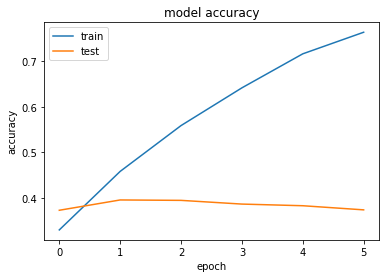

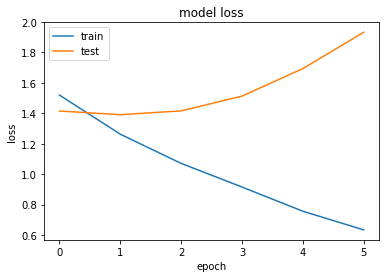

In [19]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW

import matplotlib.pyplot as plt
%matplotlib inline
from keras.callbacks import ModelCheckpoint

mcp1 = ModelCheckpoint('weights.best.hdf5', monitor="val_acc",save_best_only=True, save_weights_only=False)

bs = 64
n_epochs = 6

history = model.fit(x_train_pad, y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(x_val_pad, y_val), callbacks = [mcp1])

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.
model = keras.models.load_model('weights.best.hdf5') #best score on dev 0.3951
prediction_test_one_hot = model.predict(x_test_pad)
prediction_test = [np.argmax(pred) for pred in prediction_test_one_hot]

def write_submission(path_output,prediction):
    #function that write the submission
    lines = '\n'.join([str(p) for p in prediction])
    with open(path_output,'w') as f:
        f.writelines(lines)

    
write_submission(os.path.join('.',r'logreg_lstm_y_test_sst.txt'),prediction_test)

4


## 4.3 -- innovate !

In [70]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation,Dropout,Conv1D,Flatten
from keras.layers import Bidirectional 
from keras.optimizers import RMSprop
from keras import backend as K

embed_dim  = 300  # word embedding dimension
nhid       = 50  # number of hidden units in the LSTM
vocab_size = nb_words  # size of the vocabulary
n_classes  = 5

list_w = set([w for sent in (x_train+x_dev+x_test) for w in sent ])

mcp1 = ModelCheckpoint('weights.best_innovate.hdf5', monitor="val_acc",save_best_only=True, save_weights_only=False)

#Create the pretrained embedding matrix

embedding_matrix = np.zeros((vocab_size, embed_dim))
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)
for w in list_w:
    if w in w2v.word2vec:

        index = w,text.one_hot(w,nb_words)
        if len(index)==1:
            id_w = text.one_hot(w,nb_words)[0]
            embedding_matrix[id_w] = w2v.word2vec[w]

model = Sequential()
model.add(Embedding(vocab_size, embed_dim, weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(nhid, dropout_W=0.3, dropout_U=0.3,return_sequences=False))) #bidirectional layer
model.add(Dense(n_classes, activation='softmax'))

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  RMSprop(lr=0.001,decay=0.00001) # find the right optimizer
metrics_classif  =  ['accuracy']

model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

bs = 64
n_epochs = 8

history = model.fit(x_train_pad, y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(x_val_pad, y_val),callbacks = [mcp1])

model = keras.models.load_model('weights.best_innovate.hdf5') #best score on dev 0.3915


get_layer_output = K.function([model.layers[0].input,K.learning_phase()], [model.layers[1].output])
layer_output_train = get_layer_output([x_train_pad, 0])[0]
layer_output_dev = get_layer_output([x_val_pad, 0])[0]
layer_output_test = get_layer_output([x_test_pad,0])[0]

from sklearn.svm import SVC #use a svm on the last layer
from sklearn.metrics import accuracy_score

y_train_rf = np.argmax(y_train,axis=1)
y_dev_ref = y_dev

rf =SVC(C=0.3)
rf.fit(layer_output_train,y_train_rf)
prediction_dev = rf.predict(layer_output_dev)
prediction_train = rf.predict(layer_output_train)
prediction_test = rf.predict(layer_output_test)

print 'Precision sur le train set', accuracy_score(y_train_rf,prediction_train)
print 'Precision sur le dev set', accuracy_score(y_dev_ref,prediction_dev)

write_submission(os.path.join('.',r'bidirectional_lstm_svm_y_test_sst.txt'),prediction_test)

Loaded 200000 pretrained word vectors


/home/ratnamogan/anaconda3/envs/TD_1/lib/python2.7/site-packages/ipykernel_launcher.py:37: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(50, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 300)         5861400   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 100)               140400    
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 505       
Total params: 6,002,305
Trainable params: 6,002,305
Non-trainable params: 0
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/8
8544/8544 [==============================] - 25s 3ms/step - loss: 1.5201 - acc: 0.3246 - val_loss: 1.4217 - val_acc: 0.3769
Epoch 2/8
8544/8544 [==============================] - 20s 2ms/step - loss: 1.2770 - acc: 0.4607 - val_loss: 1.3668 - val_acc: 0.3915
Epoch 3/8
8544/8544 [==============================] - 19s 2ms/step - loss: